In [1]:
import os
import sys
import glob

import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras.backend.tensorflow_backend import set_session

import matplotlib.pyplot as plt

import nibabel as nib

Using TensorFlow backend.


In [47]:
def plot(img):
    plt.figure()
    plt.imshow(img[:, 40, :], cmap='gray')
    
def load_nii(path):
    nii = nib.load(path)
    vol = nii.get_data().astype(np.float32)
    return np.squeeze(vol)

In [2]:
run_dirs = glob.glob('../runs/*/predict')
run_dirs = sorted(run_dirs)

print('found {} runs'.format(len(run_dirs)), '\n')

for i, run in enumerate(run_dirs):
    print(i, run, '\n')

found 2 runs 

0 ../runs/gan_20190428_1448_gpu=7_bs=4_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=0.1_pl=50.0_vr=0.5_is=5_cs=5_rf=10_rs=5_sw=True_glw=[1_100_500_10_0]_clw=[1_1_10]/predict 

1 ../runs/gan_20190430_1720_gpu=7_bs=16_cl=8_lr=0.0001_b1=0.0_b2=0.9_ep=0.1_pl=50.0_lk=0.2_bn=True_vr=0.5_is=6_cs=5_rf=10_rs=5_sw=True_glw=[1_100_500_10_0_0]_clw=[1_1_10]_tag=beefier_decoder_more_summaries_batchnorm/predict 



In [4]:
# set run dir
run_dir = run_dirs[1]

pre_dirs = glob.glob(os.path.join(glob.escape(run_dir), '*', '*'))
pre_dirs = sorted(pre_dirs)

print('found {} pre_dirs'.format(len(pre_dirs)))

for i, pre_dir in enumerate(pre_dirs):
    #print(i, os.path.basename(pre_dir))
    print(i, pre_dir.split('/')[-2] + '/' + pre_dir.split('/')[-1])

found 3 pre_dirs
0 eval/gen_090
1 eval/gen_090_04
2 test/gen_090_04


In [5]:
# generator config, run_dir, etc...
pre_dir = pre_dirs[0]

csv_path = os.path.join(pre_dir, 'meta.csv')
csv = pd.read_csv(csv_path)

print('found meta.csv: {}'.format(csv.shape))

found meta.csv: (2408, 39)


In [52]:
# regressor
reg_dir = '../../age/runs/reg_20190427_2348_gpu=2_bs=16_lr=0.0001_b1=0.9_b2=0.999_ep=0.1_bn=True_mp=True_lk=0.0_ls=[8_2_32_2_64_1_64_2_128_1_128_2_256_1_256_1_256_1]_lw=[1.0]_ls=mean_absolute_error_tag=slice/'
model_name = 'reg_0900'
model_file = os.path.join(reg_dir, model_name+'.h5')

if os.path.isfile(model_file):
    print('found model file')
else:
    print('model file not found!')

found model file


In [53]:
# gpu config
gpu_id = 2

if gpu_id is not None:                                                     
    gpu = '/gpu:' + str(gpu_id)                                            
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)                       
    config = tf.ConfigProto()                                              
    config.gpu_options.allow_growth = True                                 
    config.allow_soft_placement = True                                     
    set_session(tf.Session(config=config))                                 
else:                                                                      
    gpu = '/cpu:0'

In [54]:
csv = csv[~csv.img_path_0.isna()]
csv = csv[~csv.img_path_1.isna()]
csv = csv[~csv.img_path_yf.isna()]

csv = csv.reset_index(drop=True)

print('starting predict')

with tf.device(gpu):
    
    # load classifier model
    regressor = keras.models.load_model(model_file)
    
    for i, (_, row) in enumerate(csv.iterrows()):
        
        if i % 10 == 0:
            print('step', i)
        
        xr = load_nii(row['img_path_0'])[None, ..., None]
        yr = load_nii(row['img_path_1'])[None, ..., None]
        yf = load_nii(row['img_path_yf'])[None, ..., None]
        
        batch = np.concatenate([xr, yr, yf], axis=0)
        
        pred = regressor.predict([batch])
        
        index = (csv.img_id_0 == row['img_id_0']) & (csv.img_id_1 == row['img_id_1'])
        
        csv.loc[index, 'age_xr'] = pred[0]
        csv.loc[index, 'age_yr'] = pred[1]
        csv.loc[index, 'age_yf'] = pred[2]
        
print('finished predict')

csv_out_path = os.path.join(pre_dir, model_name+'.csv')

print('writing csv to {}'.format(csv_out_path))

csv.to_csv(csv_out_path, index=False)

starting predict
step 0
step 10
step 20
step 30
step 40
step 50
step 60
step 70
step 80
step 90
step 100
step 110
step 120
step 130
step 140
step 150
step 160
step 170
step 180
step 190
step 200
step 210
step 220
step 230
step 240
step 250
step 260
step 270
step 280
step 290
step 300
step 310
step 320
step 330
step 340
step 350
step 360
step 370
step 380
step 390
step 400
step 410
step 420
step 430
step 440
step 450
step 460
step 470
step 480
step 490
step 500
step 510
step 520
step 530
step 540
step 550
step 560
step 570
step 580
step 590
step 600
step 610
step 620
step 630
step 640
step 650
step 660
step 670
step 680
step 690
step 700
step 710
step 720
step 730
step 740
step 750
step 760
step 770
step 780
step 790
step 800
step 810
step 820
step 830
step 840
step 850
step 860
step 870
step 880
step 890
step 900
step 910
step 920
step 930
step 940
step 950
step 960
step 970
step 980
step 990
step 1000
step 1010
step 1020
step 1030
step 1040
step 1050
step 1060
step 1070
step 1080
step

In [6]:
reg_csvs = glob.glob(os.path.join(glob.escape(pre_dir), '[!meta]*.csv'))
reg_csvs = sorted(reg_csvs)

for i, reg_csv in enumerate(reg_csvs):
    print(i, os.path.basename(reg_csv))

0 reg_0900.csv
1 reg_1000.csv


In [7]:
csv_path = reg_csvs[1]
csv = pd.read_csv(csv_path)
print(csv.shape)

(2408, 42)


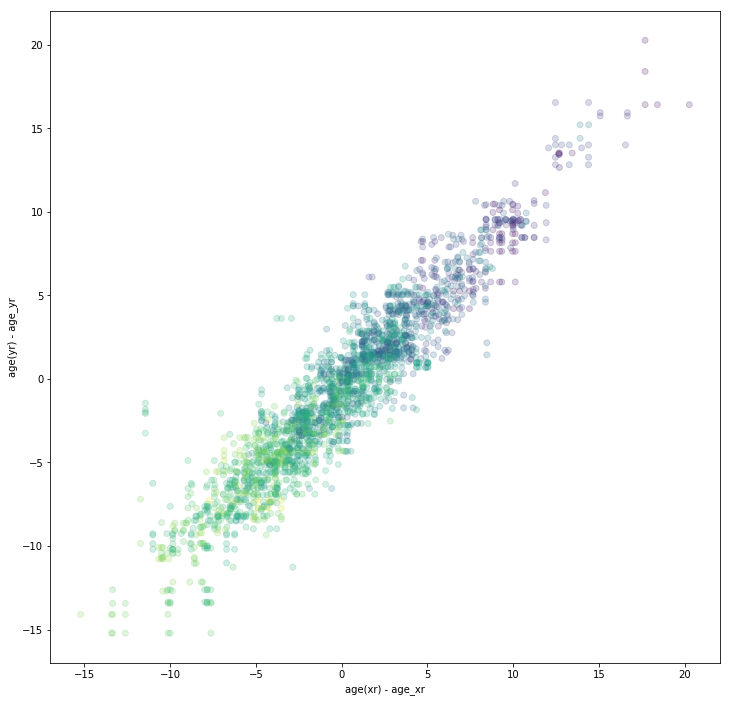

In [8]:
x = csv.age_xr - csv.pat_age_0
y = csv.age_yr - csv.pat_age_1
c = (csv.pat_age_0 + csv.pat_age_1) / 2

plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=c, alpha=0.2)
plt.xlabel('age(xr) - age_xr')
plt.ylabel('age(yr) - age_yr')
plt.show()

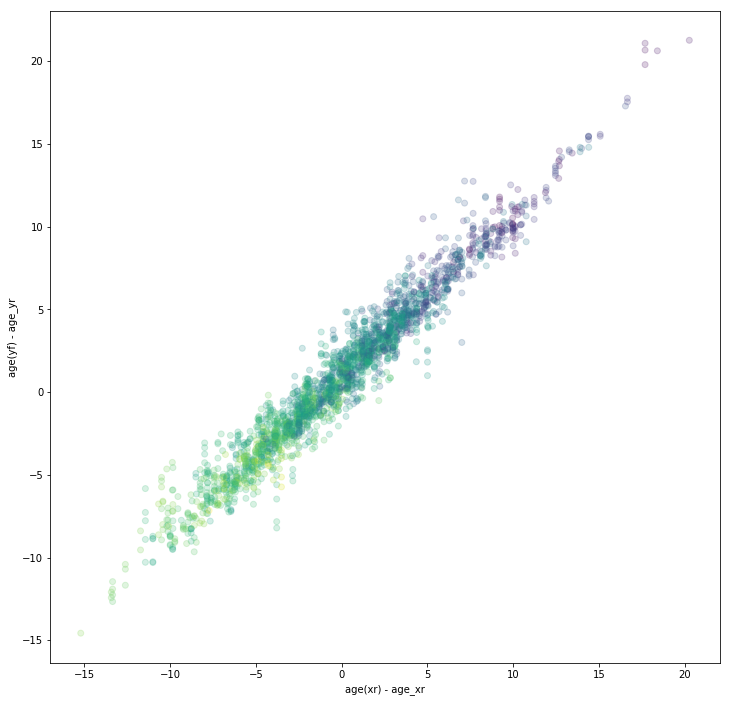

In [9]:
x = csv.age_xr - csv.pat_age_0
y = csv.age_yf - csv.pat_age_1
c = (csv.pat_age_0 + csv.pat_age_1) / 2

plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=c, alpha=0.2)
plt.xlabel('age(xr) - age_xr')
plt.ylabel('age(yf) - age_yr')
plt.show()

In [13]:
def linear_reg(x, y):
    beta = ((x - x.mean()) * (y - y.mean())).sum() / ((x - x.mean())**2).sum()
    alpha = y.mean() - (beta * x.mean())
    
    return alpha, beta

(1333, 42)
1 - alpha: 0.02716675433189808, beta: 0.574524843952577
(616, 42)
2 - alpha: 0.32460375280813025, beta: 0.5481412994326686
(459, 42)
3 - alpha: 0.3486605870740388, beta: 0.6116594702777677


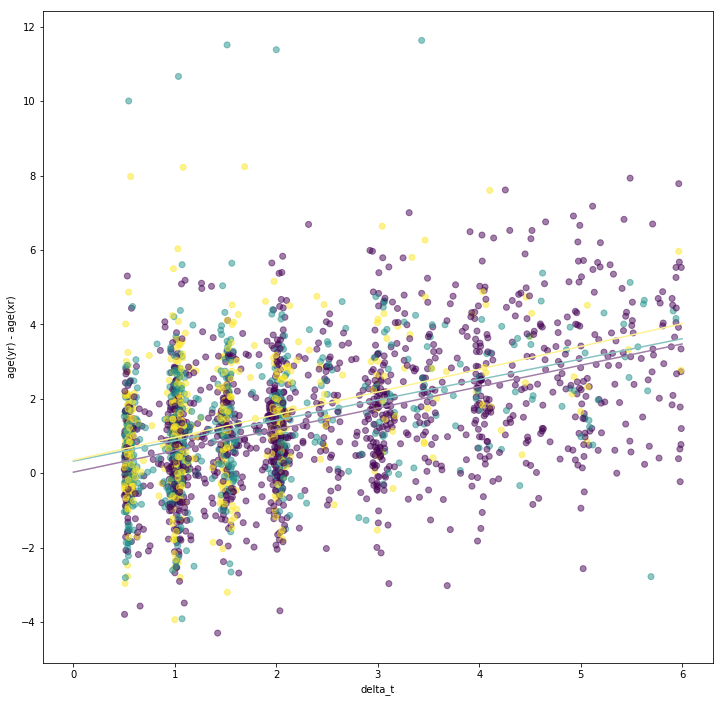

In [19]:
x = csv.delta_t / 365
y = csv.age_yr - csv.age_xr
c = csv.pat_dx_1

plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=c, alpha=0.5)
plt.xlabel('delta_t')
plt.ylabel('age(yr) - age(xr)')

color_dx = ['#A07EA8', '#87C3C1', '#FDF291']
x_lr = np.linspace(0, 6, 2)

for dx in range(1, 4):
    csv_dx = csv[csv.pat_dx_1 == dx]
    print(csv_dx.shape)
    x = csv_dx.delta_t / 365
    y = csv_dx.age_yr - csv_dx.age_xr
    
    alpha, beta = linear_reg(x, y)
    
    print('{} - alpha: {}, beta: {}'.format(dx, alpha, beta))
    
    plt.plot(x_lr, alpha + beta * x_lr, color_dx[dx-1])

plt.show()

(1333, 42)
1 - alpha: 1.279403783804117, beta: 0.9362689150520394
(616, 42)
2 - alpha: 0.961663043405472, beta: 0.9742615038566472
(459, 42)
3 - alpha: 0.9785411081144484, beta: 1.0222141079309002


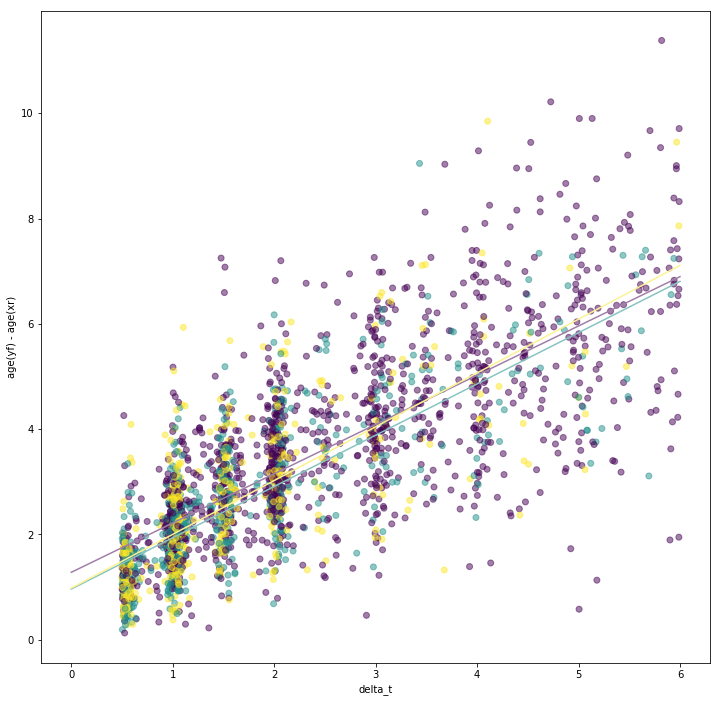

In [20]:
x = csv.delta_t / 365
y = csv.age_yf - csv.age_xr
c = csv.pat_dx_1

plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=c, alpha=0.5)
plt.xlabel('delta_t')
plt.ylabel('age(yf) - age(xr)')

color_dx = ['#A07EA8', '#87C3C1', '#FDF291']
x_lr = np.linspace(0, 6, 2)

for dx in range(1, 4):
    csv_dx = csv[csv.pat_dx_1 == dx]
    print(csv_dx.shape)
    x = csv_dx.delta_t / 365
    y = csv_dx.age_yf - csv_dx.age_xr
    
    alpha, beta = linear_reg(x, y)
    
    print('{} - alpha: {}, beta: {}'.format(dx, alpha, beta))
    
    plt.plot(x_lr, alpha + beta * x_lr, color_dx[dx-1])

plt.show()

(1333, 42)
1 - alpha: 2.881769914857217, beta: 0.479847161289646
(616, 42)
2 - alpha: 2.12136722571995, beta: 0.3782684663205623
(459, 42)
3 - alpha: 2.125136708108253, beta: 0.3344607610363925


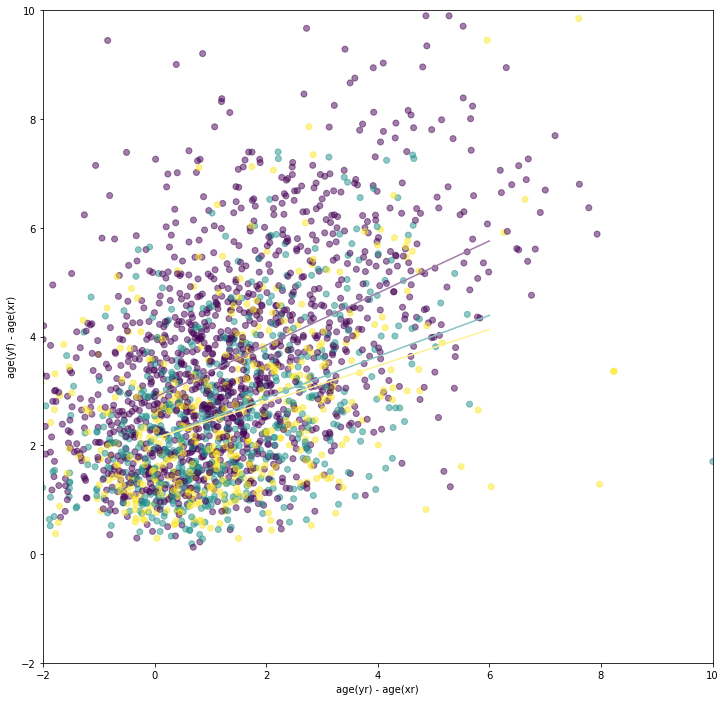

In [22]:
x = csv.age_yr - csv.age_xr
y = csv.age_yf - csv.age_xr
c = csv.pat_dx_1

plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=c, alpha=0.5)
plt.xlabel('age(yr) - age(xr)')
plt.ylabel('age(yf) - age(xr)')

color_dx = ['#A07EA8', '#87C3C1', '#FDF291']
x_lr = np.linspace(0, 6, 2)

for dx in range(1, 4):
    csv_dx = csv[csv.pat_dx_1 == dx]
    print(csv_dx.shape)
    x = csv_dx.age_yr - csv_dx.age_xr
    y = csv_dx.age_yf - csv_dx.age_xr
    
    alpha, beta = linear_reg(x, y)
    
    print('{} - alpha: {}, beta: {}'.format(dx, alpha, beta))
    
    plt.plot(x_lr, alpha + beta * x_lr, color_dx[dx-1])

plt.xlim(-2, 10)    
plt.ylim(-2, 10)    

plt.show()